Make training and test data

hr is gas positions from TNG300-1.

lr is dark matter positions from Arepo with 128 particles.

In [1]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import Pk_library as PKL
from os import mkdir, path
from shutil import rmtree
from tqdm import tqdm

In [2]:
def normalize(x, mean, std): return (x - mean) / std

def sigmoid(x): return 1/(1+np.exp(-x))

def softplus(x, eps=10e-6): return np.log(1+np.exp(x))

def inv_softplus(x, eps=10e-6): return np.log(np.exp(x)-1+eps)

def regularize(x, mean, std): return sigmoid(normalize(x, mean, std))*2 - 1

def inv_regularize(x, mean, std):
    x = (x+1)/2
    return (np.log(x/(1-x)))*std + mean

def load_data(path): return np.log1p(np.load(path))

base_dir = '/home/sr_cosmology/data/full_cubes/'

Inspect training data

In [3]:
hr_gas = load_data(base_dir+'hr/gas_density_CIC_264px.npy')
lr_trn = load_data(base_dir+'lr/dm_CIC_arepo_264px_128p_TNG300.npy')

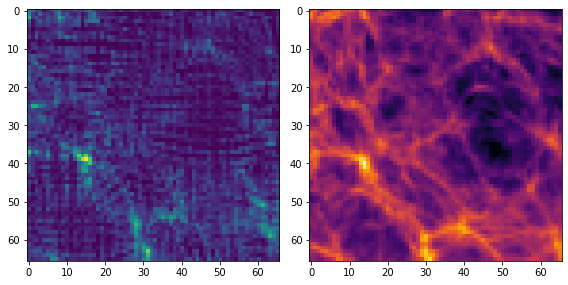

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
plot1 = ax[0].imshow(np.mean(np.log1p(lr_trn[:66, :66, :22]), axis=-1))
plot2 = ax[1].imshow(np.mean(np.log1p(hr_gas[:66, :66, :22]), axis=-1), cmap='inferno')
plt.tight_layout()

In [9]:
shift_hr = hr_gas.mean()
shift_lr = lr_trn.mean()
scale_hr = hr_gas.std()*2
scale_lr = lr_trn.std()*4

hr_gas_reg = regularize(hr_gas, shift_hr, scale_hr)
lr_trn_reg = regularize(lr_trn, shift_lr, scale_lr)

hr_gas_again = inv_regularize(hr_gas_reg, shift_hr, scale_hr)
lr_trn_again = inv_regularize(lr_trn_reg, shift_lr, scale_lr)

In [10]:
print(shift_hr, shift_lr, scale_hr, scale_lr)

5.4580938751245895 0.084621996 2.518257756763228 0.7193434834480286


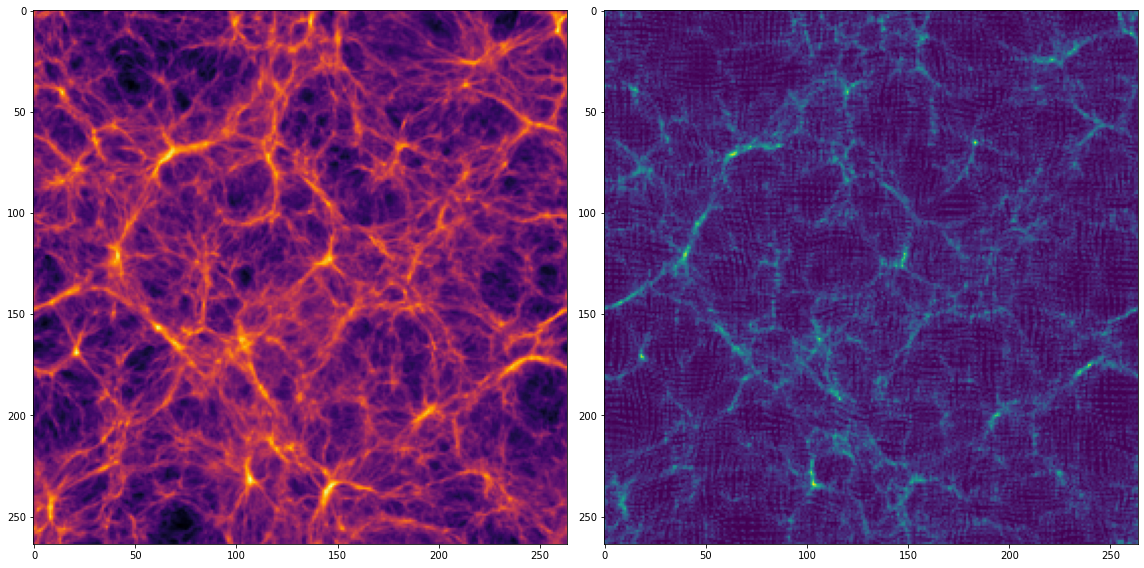

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
plot1 = ax[0].imshow(np.mean(hr_gas_reg[:, :, :22], axis=-1), cmap='inferno')
plot2 = ax[1].imshow(np.mean(lr_trn_reg[:, :, :22], axis=-1))
plt.tight_layout()

Make training data

In [16]:
crop = 48

In [19]:
def generate_sequential_pairs(directory, crop, stride):
    mkdir(directory)
    mkdir(f'{directory}/hr')
    mkdir(f'{directory}/lr')
    
    fnames = []
    i = 0

    for x_start in range(0, 264-stride, stride):
        for y_start in range(0, 264-stride, stride):
            for z_start in range(0, 264-stride, stride):
                x_end = x_start + crop
                y_end = y_start + crop
                z_end = z_start + crop

                fname = f'{i}-x-{x_start}-y-{y_start}-z-{z_start}'
                fnames.append(fname)

                img_gas = hr_gas_reg[x_start:x_end, y_start:y_end, z_start:z_end].astype(np.float32)
                np.save(f'{directory}/hr/{fname}', img_gas)

                img_lr = lr_trn_reg[x_start:x_end, y_start:y_end, z_start:z_end].astype(np.float32)
                np.save(f'{directory}/lr/{fname}', img_lr)
                        
    np.savetxt(f'{directory}/flist.txt', np.array(fnames, dtype=str), '%s', encoding='utf-8')
    print(f'Generated {len(fnames)} images for {directory} dataset.')

In [20]:
generate_sequential_pairs('tile_arepo_48px_128p', 48, 24)

Generated 1000 images for tile_arepo_48px_128p dataset.


In [22]:
def generate_pairs(directory, n_samples_per_pair):
    rng = np.random.default_rng(43)

    fnames = []

    for j in range(n_samples_per_pair):

        # Random crop
        [x_start, y_start, z_start] = rng.integers(0, hr_gas_reg.shape[0] - crop, size=3)
        x_end = x_start + crop
        y_end = y_start + crop
        z_end = z_start + crop
        
        # Random permutation
        transpose_list = rng.permutation((0, 1, 2))
        
        # Random mirror
        do_mirror = rng.integers(0, 2)

        fname = f'0-{j}'
        fnames.append(fname)

        img_gas = hr_gas_reg[x_start:x_end, y_start:y_end, z_start:z_end].astype(np.float32)
        img_gas.transpose(transpose_list)
        if do_mirror:
            img_gas = img_gas[..., ::-1]
        np.save(f'{directory}/hr/{fname}', img_gas)

        img_lr = lr_trn_reg[x_start:x_end, y_start:y_end, z_start:z_end].astype(np.float32)
        img_lr.transpose(transpose_list)
        if do_mirror:
            img_lr = img_lr[..., ::-1]
        np.save(f'{directory}/lr/{fname}', img_lr)

In [24]:
generate_pairs('train_arepo_48px_128p', 16000)

In [25]:
hr_gas_reg = np.roll(hr_gas_reg, (132, 132, 132))
lr_trn_reg = np.roll(lr_trn_reg, (132, 132, 132))

In [26]:
generate_pairs('train_arepo_48px_128p', 8000)

In [27]:
fnames = []

for j in range(16000):
    fname = f'0-{j}'
    fnames.append(fname)
np.savetxt('train_arepo_48px_128p/flist.txt', np.array(fnames, dtype=str), '%s', encoding='utf-8')